# Transformer Application

## Configuration

### Hyperparameters

In [1]:
from CustomLoss import CustomEmbeddingSliceLoss
import torch.nn as nn
import matplotlib.pyplot as plt

# HYPERPARAMETERS
BATCH_SIZE = 26
LEARNING_RATE = 0.0005

#transformer
NUM_HEADS = 6 # Dividers of 170: {1; 2; 3; 5; 6; 9; 10; 15; 18; 27; 30; 45; 54; 90; 135; 270}
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROPOUT=0.25

# Methods
loss_function = CustomEmbeddingSliceLoss()

### Constants

In [2]:
# CONSTANTS
FEATURE_DIM = 282

## Load Prepared Tensors from Disk
Run file `prototype_dataset.ipynb` first

In [3]:
import torch

train_sequence_input = torch.load('data/prototype_dataset/train_sequence_input.pt')
train_sequence_output = torch.load('data/prototype_dataset/train_sequence_output.pt')
test_sequence_input = torch.load('data/prototype_dataset/test_sequence_input.pt')
test_sequence_output = torch.load('data/prototype_dataset/test_sequence_output.pt')

In [4]:
from dataset_helper import warn_if_contains_NaN

warn_if_contains_NaN(train_sequence_input)
warn_if_contains_NaN(train_sequence_output)
warn_if_contains_NaN(test_sequence_input)
warn_if_contains_NaN(test_sequence_output)

In [5]:
print(train_sequence_input.size())
print(train_sequence_output.size())
print(test_sequence_input.size())
print(test_sequence_output.size())

torch.Size([221, 10, 282])
torch.Size([221, 10, 282])
torch.Size([53, 10, 282])
torch.Size([53, 10, 282])


## Build Dataloader with Batches

In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_dataloader = DataLoader(TensorDataset(train_sequence_input.float(), train_sequence_output.float()),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)
val_dataloader = DataLoader(TensorDataset(test_sequence_input.float(), test_sequence_output.float()),
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            drop_last=True)

In [7]:
len(train_dataloader)

8

## Initialize

In [8]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)
torch.__version__

'2.1.1'

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [10]:
from torch import nn
from AnimationTransformer import AnimationTransformer

model = AnimationTransformer(
    dim_model=FEATURE_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout_p=DROPOUT,
    use_positional_encoder=True
).to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_param = sum(p.numel() for p in model.parameters())
print(f"The model has {total_param} trainable parameters")

The model has 13102312 trainable parameters


## Training

In [11]:
from AnimationTransformer import fit

train_loss_list, validation_loss_list = fit(model,
                                            optimizer,
                                            loss_function,
                                            train_dataloader,
                                            val_dataloader,
                                            epochs=2,
                                            device=device)

Training and validating model
------------------------- Epoch 1 -------------------------


c:\Users\okan2\anaconda3\envs\animationSVG\lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


>> 1: Time per Batch  0.93s | Total expected  0.12 min | Remaining  0.11 min 
>> Epoch time: 0.07 min
Training loss: 184.9804
Validation loss: 293.6704

------------------------- Epoch 2 -------------------------


c:\Users\okan2\anaconda3\envs\animationSVG\lib\site-packages\torch\nn\modules\transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


>> 1: Time per Batch  0.52s | Total expected  0.07 min | Remaining  0.06 min 
>> Epoch time: 0.07 min
Training loss: 190.3060
Validation loss: 292.8982



In [12]:
# Define the number of additional epochs you want to train for
additional_epochs = 2

# Continue training the model for more epochs
new_train_loss, new_validation_loss = fit(model,
                                          optimizer,
                                          loss_function,
                                          train_dataloader,
                                          val_dataloader,
                                          epochs=additional_epochs,
                                          device=device)

# Extend the original loss lists with the new loss values
train_loss_list.extend(new_train_loss)
validation_loss_list.extend(new_validation_loss)

Training and validating model
------------------------- Epoch 1 -------------------------
>> 1: Time per Batch  0.52s | Total expected  0.07 min | Remaining  0.06 min 
>> Epoch time: 0.07 min
Training loss: 189.2924
Validation loss: 291.7509

------------------------- Epoch 2 -------------------------
>> 1: Time per Batch  0.56s | Total expected  0.07 min | Remaining  0.06 min 
>> Epoch time: 0.07 min
Training loss: 189.7310
Validation loss: 291.4791



In [13]:
print("Train\n", "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))

Train
 184,9804; 190,3060; 189,2924; 189,7310


In [14]:
print("Validation\n", "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))

Validation
 293,6704; 292,8982; 291,7509; 291,4791


## Training and Validation Loss Plot

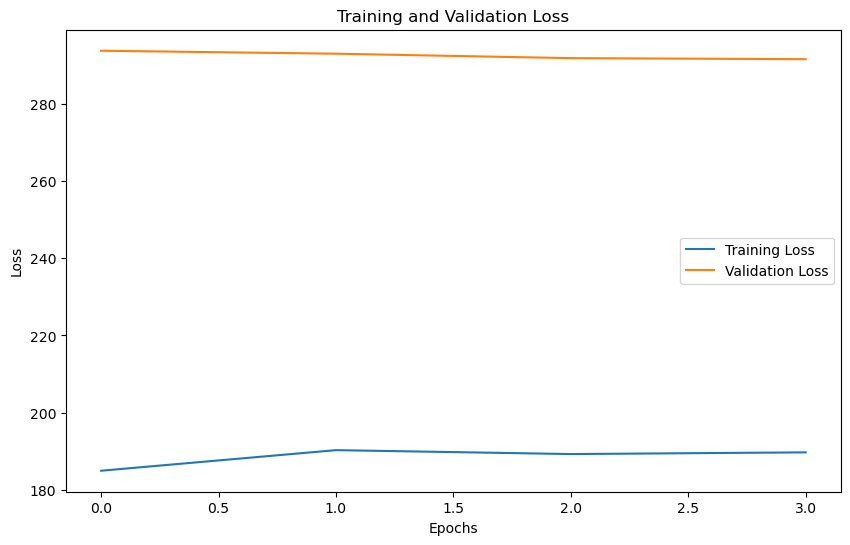

In [15]:
# # Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Prediction

In [16]:
# Create a tensor of zeros with 270 elements
sos_token = torch.zeros(282)
# Set the value at the 256 index to 1
sos_token[256] = 1

In [17]:
from AnimationTransformer import predict

predict(model, test_sequence_input[10], sos_token=sos_token, device=device, max_length=10, eos_scaling=0.01)

2: Path 0 (18.302) got animation 2 (0.106%) with parameters [0.73, -1.42, -1.0, -1.0, 0.03, 0.54, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
3: Path 0 (18.285) got animation 2 (0.107%) with parameters [0.73, -1.43, -1.0, -1.0, 0.03, 0.54, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
4: Path 0 (18.285) got animation 2 (0.107%) with parameters [0.73, -1.43, -1.0, -1.0, 0.03, 0.54, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
5: Path 0 (18.285) got animation 2 (0.107%) with parameters [0.73, -1.43, -1.0, -1.0, 0.03, 0.54, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
6: Path 0 (18.284) got animation 2 (0.107%) with parameters [0.73, -1.43, -1.0, -1.0, 0.03, 0.54, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
7: Path 0 (18.284) got animation 2 (0.107%) with parameters [0.73, -1.43, -1.0, -1.0, 0.03, 0.54, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
8: Path 0 (18.284) got animation 2 (0.107%) with parameters [0.73, -1.43, -1.0, -1.0, 0.

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0877, -1.3243,  0.2504,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0877, -1.3243,  0.2504,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 0.0877, -1.3243,  0.2504,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0877, -1.3243,  0.2504,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.0877, -1.3243,  0.2504,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [19]:
# Sequences with long input
test_sequence_input[50, :, 0] # 50, 10, 220, 222, 600

tensor([  -1.4797,    0.1024,    0.1024,   -1.4797,   -0.5534,   -0.5534,
        -100.0000, -100.0000, -100.0000, -100.0000], dtype=torch.float64)

In [20]:
# check sequence length / embedding
print(test_sequence_output[50, :, -26:])
print(test_sequence_input [50, :, -26:])

IndexError: index 222 is out of bounds for dimension 0 with size 53

# Hyperparameter Tuning

In [ ]:
from AnimationTransformer import validation_loop, train_loop
import optuna
from torch.utils.data import DataLoader

MAX_EPOCHS = 5

def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_encoder_layers = trial.suggest_categorical('num_encoder_layers', [2, 4, 6])
    num_decoder_layers = trial.suggest_categorical('num_decoder_layers', [4, 6, 8])
    # batch_size = trial.suggest_categorical('batch_size', [64])
    num_heads = trial.suggest_categorical('num_heads', [9, 15, 27, 45, 90])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    use_positional_encoder = trial.suggest_categorical('pos_encoder_max_len', [True, False])
    
    print(f'Parameters selected')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout')
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate}; {num_heads}; {use_positional_encoder}; {dropout}'.replace('.', ','))
    
    # Instantiate the model with suggested hyperparameters
    model = AnimationTransformer(
        dim_model=FEATURE_DIM,
        num_heads=num_heads,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout_p=dropout,
        use_positional_encoder=use_positional_encoder
    ).to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_list, validation_loss_list = [], []

    validation_loss = -1
    # Training loop with early stopping, validation, etc.
    for epoch in range(MAX_EPOCHS):
        print(f' =========== EPOCH {epoch} ===========')
        
        train_loss = train_loop(model, optimizer, loss_function, train_dataloader, device)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_function, val_dataloader, device)
        validation_loss_list += [validation_loss]
        
        print(f'Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
        
        # Report the validation loss to Optuna
        trial.report(validation_loss, epoch)
        
        # Implement early stopping logic
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    print(f'Best validation loss: {validation_loss}')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout;')
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate:.8f}; {num_heads}; {use_positional_encoder}; {dropout:.8f}; Validation; '.replace('.', ','),
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))
    print(f' ; ; ; ; ; Train; ',
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))
    
    return validation_loss

Used:
- pick_and_animate_from_8     First Run
- pick_and_animate_from_8_v3  First Main Run

In [ ]:
my_study = optuna.create_study(
    direction='minimize',
    study_name='pick_and_animate_from_8', # IMPORTANT: Chance Name when new Dataset
    storage='sqlite:///animate_svg_optuna.db',
    load_if_exists=True
)

In [ ]:
#study = optuna.create_study(direction='minimize')
my_study.optimize(objective, n_trials=100)

In [ ]:
print("Best trial:")
trial = my_study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(my_study)

In [ ]:
plot_param_importances(my_study)

In [ ]:
from optuna.visualization import plot_slice

plot_slice(my_study)

In [ ]:
from optuna.visualization import plot_timeline

plot_timeline(my_study)